In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import shortfall.gradient.base_cost_models as bcm
import shortfall.gradient.optimize_burn as ob

In [5]:
initial_pledge_projection_period_days = 20
token_lease_fee = 0.2
supply_lock_target = 0.3

# define various loss functions to explore
sampling_rate = 30  # sampling rate of the income curve
    
def get_incomes(x):
    base_stats = bcm.compute_baseline(initial_pledge_projection_period_days, token_lease_fee, supply_lock_target)
    burn_stats = ob.compute_burn(x)

    indices = np.arange(sampling_rate, len(burn_stats), sampling_rate)
    # extract the quantities of interest
    income_burn = jnp.asarray([burn_stats[ii]['net_equity'] for ii in indices])
    income_base = bcm.compute_income(base_stats, borrow_amt=ob.BORROW_AMT, apy=ob.APY, sampling_rate_days=ob.SAMPLING_RATE_DAYS)
    
    return income_base, income_burn

def mse_loss(x):
    income_base, income_burn = get_incomes(x)
    mse_loss = jnp.mean(jnp.power(income_base - income_burn, 2)) / len(income_base)
    return mse_loss

In [6]:
max_shortfall_fraction_vec = np.linspace(0.1, 0.5, 10)
shortfall_pct_pow_vec = np.linspace(0, 1, 5)

loss_surface = np.zeros((len(max_shortfall_fraction_vec), len(shortfall_pct_pow_vec)))
for ii in range(len(max_shortfall_fraction_vec)):
    for jj in range(len(shortfall_pct_pow_vec)):
        x = jnp.asarray([max_shortfall_fraction_vec[ii], shortfall_pct_pow_vec[jj]])
        loss_surface[ii,jj] = mse_loss(x)

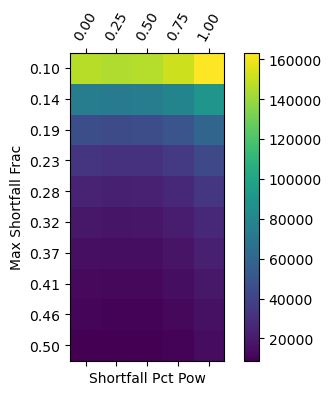

In [7]:
fig, ax = plt.subplots(figsize=[5, 4])

xt = ['%0.02f' % (x,) for x in shortfall_pct_pow_vec]
yt = ['%0.02f' % (x,) for x in max_shortfall_fraction_vec]

z = ax.matshow(loss_surface)
ax.set_xticks(range(len(xt)))
ax.set_yticks(range(len(yt)))
ax.set_xticklabels(xt, rotation=60)
ax.set_yticklabels(yt)
ax.set_xlabel('Shortfall Pct Pow')
ax.set_ylabel('Max Shortfall Frac')


fig.colorbar(z)

In [8]:
income_base, income_burn = get_incomes([0.5, 1.5])
_, income_burn2 = get_incomes([0.5, 0.25])
_, income_burn3 = get_incomes([0.5, 0.5])
_, income_burn4 = get_incomes([0.5, 0.75])
_, income_burn5 = get_incomes([0.1, 1])

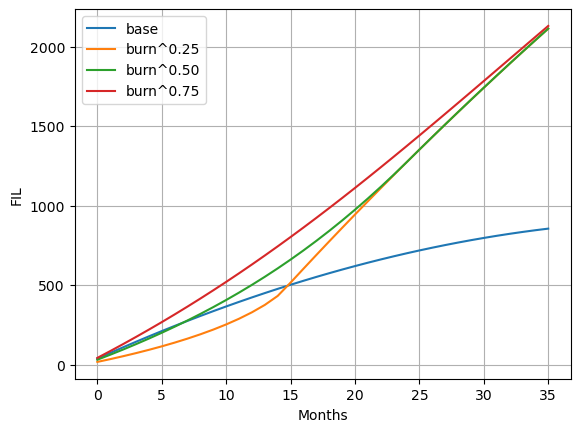

In [9]:
plt.figure()
plt.plot(income_base, label='base')
plt.plot(income_burn2, label='burn^0.25')
plt.plot(income_burn3, label='burn^0.50')
plt.plot(income_burn4, label='burn^0.75')
# plt.plot(income_burn5, label='burn^1')
plt.xlabel('Months')
plt.ylabel('FIL')
plt.grid()
plt.legend()